### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

from pycaret.classification import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [6]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
RES_PATH = 'data/result_submission.csv'

### Загрузка данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Изучение датасета

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            2500 non-null   int64  
 1   Home Ownership                2500 non-null   object 
 2   Annual Income                 1987 non-null   float64
 3   Years in current job          2414 non-null   object 
 4   Tax Liens                     2500 non-null   float64
 5   Number of Open Accounts       2500 non-null   float64
 6   Years of Credit History       2500 non-null   float64
 7   Maximum Open Credit           2500 non-null   float64
 8   Number of Credit Problems     2500 non-null   float64
 9   Months since last delinquent  1142 non-null   float64
 10  Bankruptcies                  2497 non-null   float64
 11  Purpose                       2500 non-null   object 
 12  Term                          2500 non-null   object 
 13  Cur

In [10]:
print(train_df.shape, test_df.shape)

(7500, 18) (2500, 17)


### Feature engineering / Работа с признаками

In [11]:
def feature_engineering(df):
    # Преобразование в фиктивную переменную:
    df['Home Ownership_Home Mortgage'] = (df['Home Ownership'] == 'Home Mortgage').astype('bool')
    df['Home Ownership_Rent'] = (df['Home Ownership'] == 'Rent').astype('bool')
    df['Home Ownership_Own Home'] = (df['Home Ownership'] == 'Own Home').astype('bool')
    df['Home Ownership_Home Mortgage'] = (df['Home Ownership'] == 'Have Mortgage').astype('bool')
    df.drop(['Home Ownership'], axis=1, inplace=True)
        
    # Заполнение пропусков медианой.
    Annual_Income_median = df['Annual Income'].median()
    df.loc[df['Annual Income'].isnull(), 'Annual Income'] = Annual_Income_median
        
    # Преобразование из категориальной переменной в числовую
    df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0
    df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
    df.loc[df['Years in current job'] == '2 years', 'Years in current job'] = 2
    df.loc[df['Years in current job'] == '3 years', 'Years in current job'] = 3
    df.loc[df['Years in current job'] == '4 years', 'Years in current job'] = 4
    df.loc[df['Years in current job'] == '5 years', 'Years in current job'] = 5
    df.loc[df['Years in current job'] == '6 years', 'Years in current job'] = 6
    df.loc[df['Years in current job'] == '7 years', 'Years in current job'] = 7
    df.loc[df['Years in current job'] == '8 years', 'Years in current job'] = 8
    df.loc[df['Years in current job'] == '9 years', 'Years in current job'] = 9
    df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = 10
      
    df['Years in current job'] = df['Years in current job'].astype(float)

    # Заполнение пропусков значениями, которые встречаются наиболее часто(мода)
    Years_in_current_job_mode = df['Years in current job'].mode()[0]
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = Years_in_current_job_mode
    
    # Уменьшение количества выбросов
    df.loc[df['Tax Liens'] > 5, 'Tax Liens'] = 5
    df.loc[df['Number of Open Accounts'] > 25, 'Number of Open Accounts'] = 8
    
    # Уменьшение количества выбросов
    df.loc[df['Number of Credit Problems'] > 5, 'Number of Credit Problems'] = 5
        
    # Создание колонки - «Были проблемы с кредитом», 1 - да, 0 - нет
    df['Were Credit Problems'] = (df['Number of Credit Problems'] >0).astype('bool')

    # Заполнение пропусков значениями
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 17
    df.loc[ df['Months since last delinquent'] > 65, 'Months since last delinquent'] = 17
    
    # Заполнение пропусков значениями
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

    # Преобразование в фиктивную переменную
    df['Purpose_small business'] = (df['Purpose'] == 'small business').astype('bool')
    df['Purpose_business loan'] = (df['Purpose'] == 'business loan').astype('bool')
    df['Purpose_medical bills'] = (df['Purpose'] == 'medical bills').astype('bool')
    df['Purpose_other'] = (df['Purpose'] == 'other').astype('bool')
    df['Purpose_debt consolidation'] = (df['Purpose'] == 'debt consolidation').astype('bool')
    df['Purpose_take a trip'] = (df['Purpose'] == 'take a trip').astype('bool')
    df['Purpose_wedding'] = (df['Purpose'] == 'wedding').astype('bool')
    df['Purpose_buy house'] = (df['Purpose'] == 'buy house').astype('bool')
    df['Purpose_home improvements'] = (df['Purpose'] == 'home improvements').astype('bool')
    df['Purpose_buy a car'] = (df['Purpose'] == 'buy a car').astype('bool')
    df['Purpose_vacation'] = (df['Purpose'] == 'vacation').astype('bool')
    df['Purpose_major purchase'] = (df['Purpose'] == 'major purchase').astype('bool')
    df['Purpose_moving'] = (df['Purpose'] == 'moving').astype('bool')
    df['Purpose_educational expenses'] = (df['Purpose'] == 'educational expenses').astype('bool')
    
    # Уменьшение количества выбросов - удаление малозначимых признаков
    df.drop(['Purpose'], axis=1, inplace=True)
    
    df['Long Term'] = (df['Term'] == 'Long Term')
    df.drop(['Term'], axis=1, inplace=True)
  
    # Уменьшение количества выбросов, заполнение фиксированным значением  
    df.loc[df['Current Loan Amount'] > 800000, 'Current Loan Amount'] = 0
    
    
    for col in ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance']:
        max_col_value = df[col].quantile(q=0.75) + (df[col].quantile(q=0.75) - df[col].quantile(q=0.25))*1.5
        min_col_value = df[col].quantile(q=0.25) - (df[col].quantile(q=0.75) - df[col].quantile(q=0.25))*1.5
        df.loc[(df[col] > max_col_value) | (df[col] < min_col_value), col] = df[col].mean()
        

    # Заполнение пропусков медианой
    Credit_Score_median = df['Credit Score'].median()
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = Credit_Score_median
    
    # Построение новых признаков
    df['Loan_income_ratio'] = df['Current Loan Amount'] / df['Annual Income']
    df['Balance_income_ratio'] = df['Current Credit Balance'] / df['Annual Income']
    df['Debt_income_ratio'] = df['Monthly Debt'] / (df['Annual Income'] / 12) * 100

In [12]:
feature_engineering(train_df)
feature_engineering(test_df)

In [13]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Current Loan Amount           7500 non-null   float64
 11  Current Credit Balance        7500 non-null   float64
 12  Monthly Debt                  7500 non-null   float64
 13  Cre

### Подготовка признаков

In [14]:
X = pd.get_dummies(train_df)
X.drop('Credit Default', axis=1, inplace=True)
X.drop('Id', axis=1, inplace=True)
y = train_df['Credit Default']

TARGET_NAME = 'Credit Default'

### Балансировка по целевому классу

In [15]:
def balance_df_by_target(train_df, y, portion_of_target_class=0.5, random_state=15):
    counts_0 = (train_df[TARGET_NAME] == 0).sum()
    counts_1 = (train_df[TARGET_NAME] == 1).sum()
    minor_class = 0 if (counts_0 < counts_1) else 1
    if portion_of_target_class > (counts_1 / (counts_1 + counts_0)):
        disbalance = int(counts_0 / (1-portion_of_target_class) - counts_1 - counts_0)
    else:
        disbalance = int(counts_1 / (1-portion_of_target_class) - counts_1 - counts_0)
    sample = train_df[train_df[y] == minor_class].sample(n=disbalance, replace=True, random_state=random_state)

    return pd.concat([sample, train_df], axis=0)

In [16]:
df_balanced = balance_df_by_target(pd.concat([X, y], axis=1), TARGET_NAME, 0.50, 2)
X = df_balanced.drop(columns=TARGET_NAME)
y = df_balanced[TARGET_NAME]

In [17]:
X['Credit Default'] = y

### PyCaret 2 Classification

In [18]:
clf1 = setup(data = X, target = 'Credit Default', silent = True)

,Description,Value
0,session_id,1577
1,Target,Credit Default
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(10774, 36)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


### Compare Baseline

In [19]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8631,0.9293,0.8212,0.8936,0.8559,0.7260,0.7285,0.3260
rf,Random Forest Classifier,0.8499,0.9312,0.8545,0.8443,0.8493,0.6998,0.7000,0.4280
dt,Decision Tree Classifier,0.7991,0.7997,0.8620,0.7630,0.8094,0.5987,0.6039,0.0600
lightgbm,Light Gradient Boosting Machine,0.7953,0.8759,0.8081,0.7846,0.7961,0.5906,0.5910,0.1380
catboost,CatBoost Classifier,0.7777,0.8670,0.7789,0.7735,0.7761,0.5555,0.5555,6.7400
gbc,Gradient Boosting Classifier,0.7154,0.8030,0.6859,0.7243,0.7042,0.4305,0.4313,0.6100
ada,Ada Boost Classifier,0.6991,0.7871,0.6824,0.7016,0.6915,0.3980,0.3985,0.2120
ridge,Ridge Classifier,0.6791,0.0000,0.5862,0.7141,0.6437,0.3569,0.3628,0.0440
lda,Linear Discriminant Analysis,0.6788,0.7537,0.5870,0.7133,0.6439,0.3564,0.3621,0.0520
knn,K Neighbors Classifier,0.6426,0.6940,0.6987,0.6243,0.6593,0.2861,0.2882,0.9520


### Create Model

In [20]:
model_et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8675,0.9370,0.8369,0.8892,0.8623,0.7349,0.7362
1,0.8992,0.9423,0.8713,0.9207,0.8953,0.7983,0.7994
2,0.8859,0.9448,0.8579,0.9065,0.8815,0.7717,0.7728
3,0.8727,0.9356,0.8231,0.9110,0.8648,0.7451,0.7485
4,0.8820,0.9464,0.8391,0.9152,0.8755,0.7637,0.7663
5,0.8727,0.9356,0.8284,0.9062,0.8655,0.7451,0.7478
6,0.8753,0.9350,0.8445,0.8974,0.8702,0.7505,0.7518
7,0.8767,0.9256,0.8284,0.9142,0.8692,0.7530,0.7563
8,0.8660,0.9369,0.8365,0.8864,0.8607,0.7319,0.7330
9,0.8966,0.9481,0.8606,0.9251,0.8917,0.7929,0.7948


In [21]:
model_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8371,0.9252,0.8422,0.8311,0.8367,0.6742,0.6742
1,0.8674,0.9435,0.8820,0.8545,0.8681,0.7348,0.7352
2,0.8634,0.9467,0.8820,0.8479,0.8647,0.7269,0.7275
3,0.8475,0.9311,0.8445,0.8468,0.8456,0.6949,0.6949
4,0.8753,0.9451,0.8740,0.8740,0.8740,0.7506,0.7506
5,0.8687,0.9415,0.8552,0.8764,0.8657,0.7373,0.7375
6,0.8488,0.9275,0.8499,0.8453,0.8476,0.6976,0.6976
7,0.8621,0.9311,0.8445,0.8726,0.8583,0.7240,0.7244
8,0.8554,0.9334,0.8633,0.8474,0.8552,0.7109,0.7110
9,0.8753,0.9488,0.8740,0.8740,0.8740,0.7506,0.7506


In [22]:
model_lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8000,0.8792,0.8342,0.7781,0.8052,0.6002,0.6018
1,0.7971,0.8751,0.8231,0.7792,0.8005,0.5944,0.5953
2,0.8011,0.8783,0.8284,0.7823,0.8047,0.6023,0.6034
3,0.8011,0.8769,0.8016,0.7973,0.7995,0.6021,0.6021
4,0.7997,0.8883,0.8097,0.7906,0.8000,0.5995,0.5997
5,0.8236,0.8957,0.8231,0.8209,0.8220,0.6472,0.6472
6,0.7865,0.8734,0.8016,0.7746,0.7879,0.5731,0.5734
7,0.7971,0.8794,0.8097,0.7865,0.7979,0.5942,0.5945
8,0.7798,0.8684,0.8043,0.7634,0.7833,0.5599,0.5607
9,0.8024,0.8834,0.8150,0.7917,0.8032,0.6049,0.6051


### Tune Hyperparameters

In [23]:
tuned_et = tune_model(model_et, n_iter=50, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6980,0.8124,0.7032,0.6921,0.6976,0.3961,0.3961
1,0.7414,0.8324,0.7453,0.7354,0.7403,0.4828,0.4828
2,0.7347,0.8322,0.7212,0.7370,0.7290,0.4693,0.4694
3,0.7215,0.8132,0.6568,0.7492,0.7000,0.4422,0.4455
4,0.7586,0.8336,0.7265,0.7721,0.7486,0.5169,0.5178
5,0.7533,0.8455,0.7426,0.7548,0.7486,0.5065,0.5066
6,0.7281,0.8061,0.6971,0.7386,0.7172,0.4559,0.4566
7,0.7255,0.8348,0.7051,0.7306,0.7176,0.4507,0.4509
8,0.7109,0.8154,0.6783,0.7208,0.6989,0.4213,0.4220
9,0.7361,0.8274,0.7105,0.7444,0.7270,0.4718,0.4723


In [24]:
tuned_rf = tune_model(model_rf, n_iter=50, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7192,0.8312,0.7326,0.7098,0.7211,0.4385,0.4387
1,0.7560,0.8393,0.7453,0.7575,0.7514,0.5118,0.5119
2,0.7427,0.8432,0.7641,0.7289,0.7461,0.4856,0.4862
3,0.7414,0.8341,0.7078,0.7543,0.7303,0.4824,0.4833
4,0.7772,0.8665,0.7560,0.7855,0.7705,0.5542,0.5545
5,0.7613,0.8657,0.7534,0.7615,0.7574,0.5224,0.5225
6,0.7507,0.8338,0.7292,0.7577,0.7432,0.5011,0.5014
7,0.7427,0.8516,0.7346,0.7425,0.7385,0.4853,0.4853
8,0.7374,0.8338,0.7212,0.7410,0.7310,0.4746,0.4748
9,0.7772,0.8607,0.7560,0.7855,0.7705,0.5542,0.5545


In [25]:
tuned_lgbm = tune_model(model_lgbm, n_iter=50, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8291,0.9104,0.8824,0.7952,0.8365,0.6586,0.6625
1,0.8395,0.9122,0.8874,0.8073,0.8455,0.6793,0.6826
2,0.8448,0.9308,0.8981,0.8092,0.8513,0.6900,0.6941
3,0.8263,0.9045,0.8579,0.8040,0.8301,0.6527,0.6542
4,0.8369,0.9224,0.8901,0.8019,0.8437,0.6741,0.6781
5,0.8501,0.9162,0.8686,0.8351,0.8515,0.7004,0.7009
6,0.8329,0.9175,0.8686,0.8080,0.8372,0.6660,0.6679
7,0.8355,0.9107,0.8579,0.8184,0.8377,0.6712,0.6720
8,0.8316,0.9165,0.8794,0.8000,0.8378,0.6634,0.6667
9,0.8422,0.9304,0.8901,0.8098,0.8480,0.6846,0.6880


In [26]:
tuned_rf2 = create_model('rf', n_estimators=825, max_depth=8, random_state=15, max_features=7)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7073,0.7995,0.7299,0.6947,0.7119,0.4148,0.4153
1,0.7427,0.8207,0.7292,0.7452,0.7371,0.4852,0.4853
2,0.7175,0.8134,0.7105,0.7162,0.7133,0.4349,0.4349
3,0.7162,0.8044,0.6461,0.7461,0.6925,0.4315,0.4354
4,0.7520,0.8250,0.7131,0.7688,0.7399,0.5035,0.5048
5,0.7573,0.8447,0.7399,0.7624,0.7510,0.5144,0.5146
6,0.7281,0.8028,0.6863,0.7442,0.7141,0.4557,0.4571
7,0.7162,0.8179,0.6944,0.7214,0.7077,0.4321,0.4324
8,0.7122,0.8080,0.6836,0.7203,0.7015,0.4240,0.4246
9,0.7321,0.8247,0.7131,0.7368,0.7248,0.4639,0.4642


### Ensemble Model

In [27]:
bagged_rf = ensemble_model(model_rf, n_estimators=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8225,0.9257,0.8636,0.7956,0.8282,0.6453,0.6476
1,0.8554,0.9349,0.8954,0.8267,0.8597,0.7111,0.7135
2,0.8488,0.9389,0.8847,0.8229,0.8527,0.6978,0.6997
3,0.8554,0.9272,0.8686,0.8438,0.8560,0.7109,0.7112
4,0.8621,0.9401,0.8767,0.8494,0.8628,0.7242,0.7246
5,0.8501,0.9383,0.8660,0.8368,0.8511,0.7003,0.7008
6,0.8316,0.9242,0.8633,0.8090,0.8353,0.6633,0.6648
7,0.8435,0.9265,0.8552,0.8329,0.8439,0.6871,0.6873
8,0.8462,0.9277,0.8820,0.8204,0.8501,0.6925,0.6944
9,0.8753,0.9493,0.9008,0.8550,0.8773,0.7508,0.7518


In [28]:
boosted_rf = ensemble_model(model_rf, method = 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8503,0.9349,0.8636,0.8390,0.8511,0.7007,0.7010
1,0.8727,0.9379,0.8901,0.8579,0.8737,0.7454,0.7459
2,0.8700,0.9467,0.8794,0.8609,0.8700,0.7401,0.7402
3,0.8594,0.9364,0.8525,0.8618,0.8571,0.7188,0.7188
4,0.8793,0.9468,0.8740,0.8811,0.8775,0.7586,0.7586
5,0.8714,0.9359,0.8579,0.8791,0.8684,0.7426,0.7428
6,0.8488,0.9336,0.8552,0.8417,0.8484,0.6976,0.6977
7,0.8501,0.9317,0.8606,0.8403,0.8503,0.7003,0.7005
8,0.8554,0.9379,0.8579,0.8511,0.8545,0.7109,0.7109
9,0.8926,0.9543,0.8901,0.8925,0.8913,0.7851,0.7851


### Blend Models

In [29]:
blender = blend_models(estimator_list = compare_models(n_select=5, fold = 5))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8450,0.9297,0.8583,0.8338,0.8458,0.6901,0.6904
1,0.8475,0.9356,0.8901,0.8177,0.8524,0.6952,0.6979
2,0.8568,0.9426,0.8981,0.8272,0.8612,0.7138,0.7163
3,0.8422,0.9293,0.8660,0.8240,0.8444,0.6845,0.6854
4,0.8700,0.9425,0.8740,0.8647,0.8693,0.7401,0.7401
5,0.8607,0.9397,0.8686,0.8526,0.8606,0.7215,0.7216
6,0.8369,0.9254,0.8713,0.8125,0.8409,0.6740,0.6757
7,0.8475,0.9265,0.8499,0.8431,0.8465,0.6950,0.6950
8,0.8302,0.9269,0.8579,0.8101,0.8333,0.6606,0.6618
9,0.8740,0.9540,0.8981,0.8546,0.8758,0.7481,0.7491


### Stack Models

In [30]:
stacker = stack_models(estimator_list = compare_models(n_select=5, fold = 5))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6662,0.7299,0.6096,0.6826,0.6441,0.3317,0.3336
1,0.6485,0.7159,0.5979,0.6598,0.6273,0.2963,0.2976
2,0.6167,0.7126,0.5657,0.6243,0.5935,0.2326,0.2336
3,0.6286,0.7257,0.5523,0.6458,0.5954,0.2561,0.2588
4,0.6525,0.7240,0.6005,0.6647,0.6310,0.3043,0.3057
5,0.6724,0.7474,0.6354,0.6810,0.6574,0.3443,0.3451
6,0.6088,0.6799,0.5469,0.6182,0.5804,0.2165,0.2179
7,0.6446,0.7122,0.5737,0.6625,0.6149,0.2880,0.2906
8,0.6406,0.7219,0.5737,0.6564,0.6123,0.2801,0.2823
9,0.6525,0.7216,0.6086,0.6618,0.6341,0.3044,0.3053


### Analyze Model

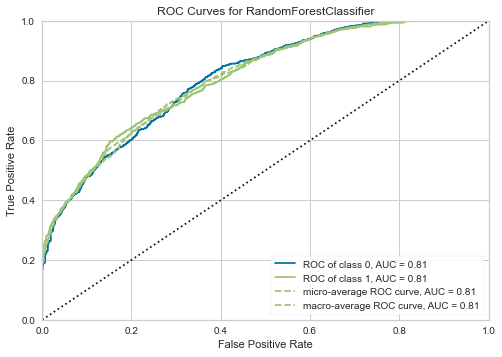

In [31]:
plot_model(tuned_rf2)

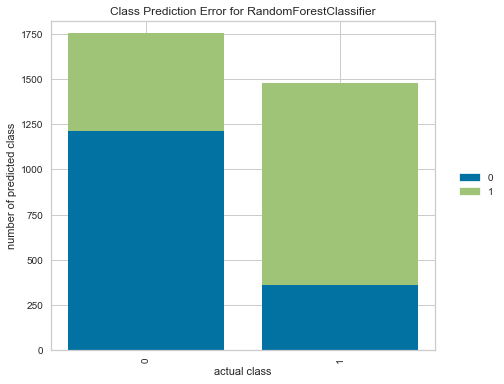

In [32]:
plot_model(tuned_rf2, plot = 'error')

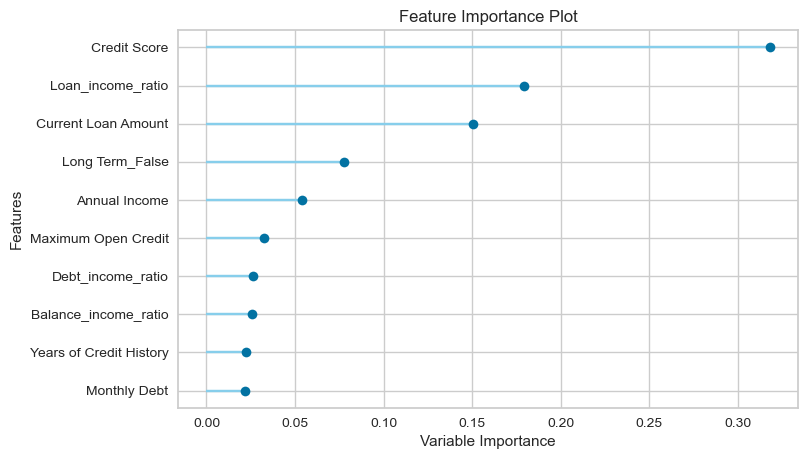

In [33]:
plot_model(tuned_rf2, plot = 'feature')

In [34]:
evaluate_model(tuned_rf2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Interpret Model

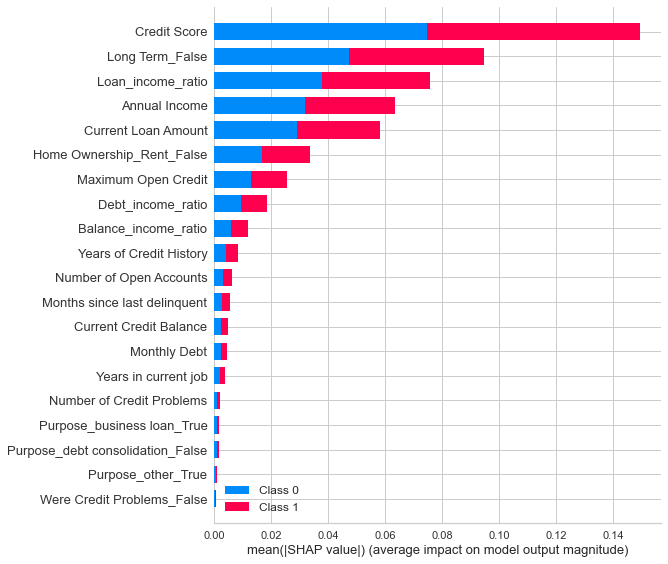

In [35]:
interpret_model(tuned_rf2)

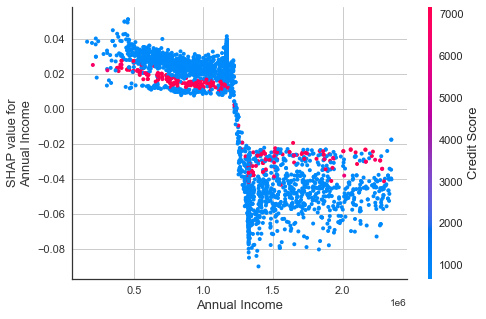

In [36]:
interpret_model(tuned_rf2, plot = 'correlation')

In [37]:
interpret_model(tuned_rf2, plot = 'reason', observation = 12)

### AutoML()

In [38]:
best = automl(optimize = 'F1')
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1577, verbose=0,
                     warm_start=False)

### Predict Model

In [39]:
pred_holdouts = predict_model(tuned_rf2)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7207,0.8104,0.6739,0.7546,0.7120,0.4425,0.4452


,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_home improvements_True,Purpose_buy a car_True,Purpose_vacation_True,Purpose_major purchase_True,Purpose_moving_True,Purpose_educational expenses_True,Long Term_False,Credit Default,Label,Score
0,1608388.00000,10.00000,0.00000,11.00000,23.50000,748682.00000,0.00000,17.00000,0.00000,683408.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,1,0.57770
1,918707.00000,2.00000,0.00000,17.00000,10.20000,354574.00000,0.00000,13.00000,0.00000,382624.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0,0,0.51940
2,1460340.00000,5.00000,0.00000,7.00000,21.30000,1001990.00000,0.00000,17.00000,0.00000,315634.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1,0,0.70560
3,1789572.00000,1.00000,0.00000,10.00000,10.00000,359656.00000,1.00000,17.00000,1.00000,330660.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,1,0.54440
4,1677472.00000,8.00000,0.00000,8.00000,24.50000,954272.00000,0.00000,17.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0,0,0.96750


In [41]:
X_test = test_df.copy()
predictions = predict_model(tuned_rf2, data=X_test)
predictions.rename(columns={'Label': 'Credit Default'}, inplace=True)
predictions.head()

,Id,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_vacation,Purpose_major purchase,Purpose_moving,Purpose_educational expenses,Long Term,Loan_income_ratio,Balance_income_ratio,Debt_income_ratio,Credit Default,Score
0,7500,1178475.00000,4.00000,0.00000,9.00000,12.50000,220968.00000,0.00000,17.00000,0.00000,...,False,False,False,False,False,0.13786,0.08987,6.93744,0,0.52680
1,7501,231838.00000,1.00000,0.00000,6.00000,32.70000,55946.00000,0.00000,8.00000,0.00000,...,False,False,False,True,False,0.33773,0.19857,11.99803,1,0.54270
2,7502,1152540.00000,3.00000,0.00000,10.00000,13.70000,204600.00000,0.00000,17.00000,0.00000,...,False,False,False,False,False,0.17368,0.12710,19.50023,1,0.90460
3,7503,1220313.00000,10.00000,0.00000,16.00000,17.00000,456302.00000,0.00000,17.00000,0.00000,...,False,False,False,False,False,0.17814,0.17471,27.10026,0,0.58650
4,7504,1328252.41800,6.00000,0.00000,11.00000,23.60000,1207272.00000,0.00000,17.00000,0.00000,...,False,False,False,False,True,0.58546,0.32026,38.49118,0,0.53820


In [42]:
test_df2 = pd.read_csv(TEST_DATASET_PATH)
test_df2['Credit Default'] = predictions['Credit Default']

In [43]:
test_df2.loc[:, ['Id', 'Credit Default']].to_csv(RES_PATH, index=False, encoding='utf-8')

In [44]:
# from google.colab import files
# files.download('./result_submission.csv')

### Save / Load Model

In [45]:
# save_model(best, model_name='best-model')

In [46]:
# loaded_bestmodel = load_model('best-model')
# print(loaded_bestmodel)

In [47]:
# from sklearn import set_config
# set_config(display='diagram')
# loaded_bestmodel[0]

In [48]:
# from sklearn import set_config
# set_config(display='text')

### Deploy Model

In [49]:
# deploy_model(best, model_name = 'best-aws', authentication = {'bucket' : 'pycaret-test'})

### Get Config / Set Config

In [50]:
# X_train = get_config('X_train')
# X_train.head()

In [51]:
# get_config('seed')

In [52]:
# from pycaret.regression import set_config
# set_config('seed', 999)

In [53]:
# get_config('seed')